# ECFP4 sizes
I want to establish whether using different-sized ECFP4 finerprints impacts predictive performance.

In [1]:
import os

import numpy as np
import pandas as pd
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_run_info(filepath):

    # Split the string at each slash to isolate each part of the path
    parts = filepath.split("/")

    # The target part is the one that contains 'params.dataset' and 'params.support_set_size'
    target = [part for part in parts if "params.dataset" in part and "params.feature" in part][0]

    # Split the target part at each comma
    params = target.split(",")

    # Split each parameter at the equals sign and take the second part
    dataset = params[0].split("=")[1]
    feature = params[1].split("=")[1]  # convert to int for numerical operations

    return {"feature": feature, "dataset": dataset}

In [4]:
run_dirs

['/Users/sethhowes/Desktop/FS-Tox/multirun/2023-08-10/14-07-57/data/processed/score/*.parquet',
 '/Users/sethhowes/Desktop/FS-Tox/multirun/2023-08-10/11-45-48/data/processed/score/*.parquet',
 '/Users/sethhowes/Desktop/FS-Tox/multirun/2023-08-10/11-08-45/data/processed/score/*.parquet',
 '/Users/sethhowes/Desktop/FS-Tox/multirun/2023-08-10/11-11-05/data/processed/score/*.parquet',
 '/Users/sethhowes/Desktop/FS-Tox/multirun/2023-08-10/11-46-00/data/processed/score/*.parquet']

In [12]:
INPUT_DIR = "/Users/sethhowes/Desktop/FS-Tox/multirun/2023-08-10/14-07-57"
run_dirs = [os.path.join(INPUT_DIR, run_dir) for run_dir in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, run_dir))]
run_dirs = [f"{run_dir}/data/processed/score/*.parquet" for run_dir in run_dirs]

datasets = ["toxcast", "toxval", "nci60", "cancerrx", "prism", "meic", "acute-oral-toxicity"]

con = duckdb.connect()

dfs = []

for run_dir in run_dirs:
    info = get_run_info(run_dir)
    query = f"""
    SELECT delta_auc_pr
    FROM read_parquet('{run_dir}')
    """
    try:
        df = con.execute(query).df()
        df["feature"] = info["feature"]
        df["dataset"] = info["dataset"]
        dfs.append(df)
    except Exception as e:
        print(f"No data for {info['dataset']} trained with feature")

        
# Concatenate all dataframes into one
df_final = pd.concat(dfs, ignore_index=True)

No data for meic trained with feature
No data for meic trained with feature
No data for meic trained with feature
No data for meic trained with feature


In [13]:
df_final.head()

,delta_auc_pr,feature,dataset
0,0.324877,ecfp4_1024,nci60
1,0.107563,ecfp4_1024,nci60
2,0.195584,ecfp4_1024,nci60
3,0.254033,ecfp4_1024,nci60
4,0.132676,ecfp4_1024,nci60


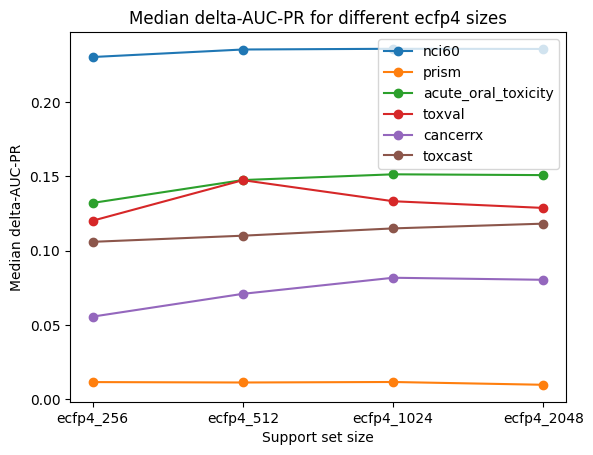

In [22]:
features = ['ecfp4_256','ecfp4_512', 'ecfp4_1024', 'ecfp4_2048']
datasets = df_final["dataset"].unique().tolist()

ecfp4_256_list = []
ecfp4_2048_list = []

# Get median delta-AUC-PR for each ecfp4 fingerprint size
non_zero_datatsets = []
for dataset in datasets:
    median_vals = []
    for feature in features:
        tmp = df_final[(df_final["feature"] == feature) & (df_final["dataset"] == dataset)]
        median_vals.append(tmp["delta_auc_pr"].median())
        if feature == 'ecfp4_256':
            ecfp4_256_list.append(tmp["delta_auc_pr"].median())
        elif feature == 'ecfp4_2048':
            ecfp4_2048_list.append(tmp["delta_auc_pr"].median())

    
    if len(tmp) != 0:
        # Plot median delta-AUC-PR for each support set size as line plot
        plt.plot(features, median_vals, marker="o", label=dataset)

plt.xlabel("Support set size")
plt.ylabel("Median delta-AUC-PR")
plt.title("Median delta-AUC-PR for different ecfp4 sizes")
plt.legend()
plt.show()

In [23]:
from statistics import mean
mean(ecfp4_256_list) - mean(ecfp4_2048_list)

-0.01133411307388113